In [1]:
from layered_atmosphere import LayeredAtmosphere, AtmosphericLayer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm

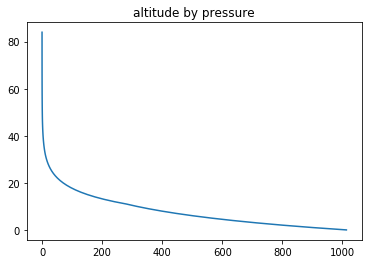

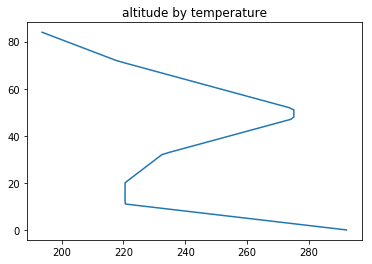

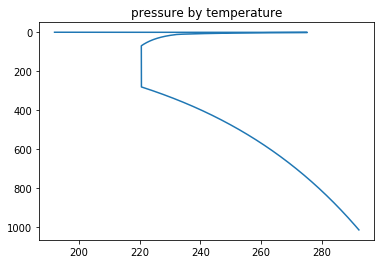

In [2]:
atm = LayeredAtmosphere.international_standard_atmosphere()

alts = np.arange(0, atm.height, 1)
temps = [atm.get_temperature_by_altitude(a) for a in alts]
press = [atm.get_pressure_by_altitude(a) / 100 for a in alts]

min_ps = atm.get_pressure_by_altitude(atm.height)
pss = np.arange(min_ps / 100, 1013.25, 0.1)
tss = [atm.get_temperature_by_pressure(p * 100) for p in pss]

plt.title('altitude by pressure'); plt.plot(press, alts); plt.show()
plt.title('altitude by temperature'); plt.plot(temps, alts); plt.show()
plt.title('pressure by temperature'); plt.plot(tss, pss); plt.gca().invert_yaxis(); plt.show()

In [3]:
def UniformSampler(a, b):
    def sampler():
        return a + (b - a) *  np.random.random()
    return sampler


def GaussianSampler(mean, std):
    def sampler():
        return norm.rvs(mean, std)
    return sampler


def GaussianSamplerBetween(a, b):
    mean = (a + b) / 2
    std = (b - a) / 8
    return GaussianSampler(mean, std)


def ConstantSampler(const):
    def sampler():
        return const
    return sampler

-0.006500000000000001 0.000875 -0.0073750000000000005 -0.005625000000000001


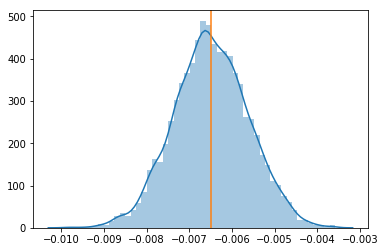

In [4]:
a, b = -0.01, -0.003

mean = (a + b)/2
std = ((b - a) / 8)
print(mean, std, mean - std, mean + std)

sas = GaussianSampler(mean, std)
asd = [min(max(a, sas()), b) for _ in range(10000)]
sns.distplot(asd)
plt.plot([mean, mean], plt.ylim())

In [5]:
class RandomLayer:
    def __init__(self, height_sampler, lapse_rate_sampler, gas_const_sampler):
        self.height_sampler = height_sampler
        self.lapse_rate_sampler = lapse_rate_sampler
        self.gas_const_sampler = gas_const_sampler


class RandomAtmosphere:
    def __init__(self, surface_temp_sampler, surface_press_sampler, *layer_samplers):
        self.surface_temp_sampler = surface_temp_sampler
        self.surface_press_sampler = surface_press_sampler
        self.layer_samplers = layer_samplers

    def sample(self):
        atm = LayeredAtmosphere()

        for i, sampler in enumerate(self.layer_samplers):
            if i == 0:
                temp = self.surface_temp_sampler()
                press = self.surface_press_sampler()
            else:
                temp = press = None
            
            try:
                atm.add_layer(sampler.height_sampler(), sampler.lapse_rate_sampler(),
                              temp, press, sampler.gas_const_sampler())
            except (OverflowError, ValueError):  # retry if conditions are too extreme
                return self.sample()             # eventually explode if parameters are really TOO extreme

        return atm


gas_const = ConstantSampler(0.28704)
rnd = RandomAtmosphere(
    GaussianSamplerBetween(273 - 100, 273 + 60),
    GaussianSamplerBetween(87000, 110000),
    RandomLayer(UniformSampler(5, 25),  GaussianSamplerBetween(-10, -0.1), gas_const),
    RandomLayer(UniformSampler(0.1, 3), GaussianSamplerBetween(-1, 1), gas_const),
    RandomLayer(UniformSampler(8, 16),  GaussianSamplerBetween(1, 2), gas_const),
    RandomLayer(UniformSampler(11, 19), GaussianSamplerBetween(2, 3), gas_const),
    RandomLayer(UniformSampler(1, 7),   GaussianSamplerBetween(-1, 1), gas_const),
    RandomLayer(UniformSampler(15, 25), GaussianSamplerBetween(-5, -0.1), gas_const),
    RandomLayer(UniformSampler(10, 20), GaussianSamplerBetween(-5, -0.1), gas_const),
)
rnd.sample()

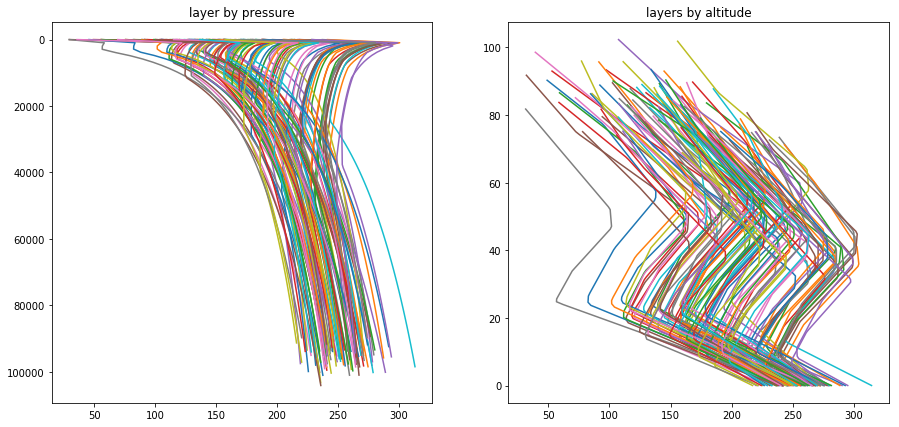

In [6]:
def plot_random_samples(rnd, count):
    plt.figure(figsize=(15, 7))
    for _ in range(count):
        ratm = rnd.sample()
        max_ps = ratm.get_pressure_by_altitude(0.1) * 0.9999
        min_ps = ratm.get_pressure_by_altitude(ratm.height) * 1.0001

        plt.subplot(1, 2, 1)
        pss = np.arange(min_ps, max_ps, (max_ps - min_ps) / 100)
        tss = [ratm.get_temperature_by_pressure(p) for p in pss]
        plt.plot(tss, pss)

        plt.subplot(1, 2, 2)
        alts = np.arange(0, ratm.height, ratm.height / 100)
        temps = [ratm.get_temperature_by_altitude(a) for a in alts]
        plt.plot(temps, alts)

    plt.subplot(1, 2, 1)
    plt.title('layer by pressure')
    plt.gca().invert_yaxis()
    plt.subplot(1, 2, 2)
    plt.title('layers by altitude')
    plt.show()


plot_random_samples(rnd, 100)

the fact that the starting altitude in the right plot seems to increase with the temperature is just an optical illusion

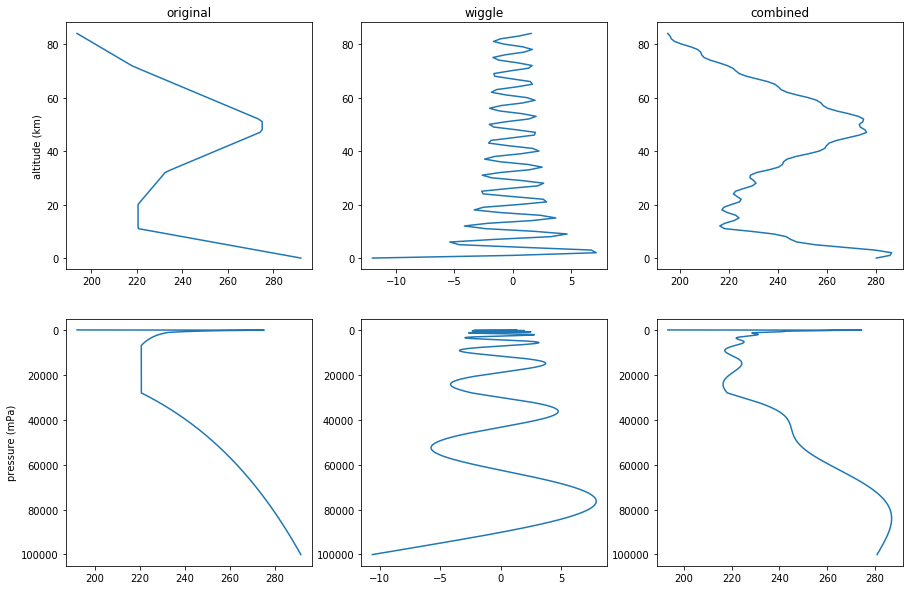

In [7]:
def display_wiggle(make_wiggle):
    atm = LayeredAtmosphere().international_standard_atmosphere()
    alts = np.arange(0, atm.height, 1)
    temps = list(map(atm.get_temperature_by_altitude, alts))
    mod = list(map(make_wiggle, alts))

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1); plt.title('original')
    plt.plot(temps, alts)
    plt.ylabel('altitude (km)')
    plt.subplot(2, 3, 2); plt.title('wiggle')
    plt.plot(mod, alts)
    plt.subplot(2, 3, 3); plt.title('combined')
    plt.plot([m + t for m, t in zip(mod, temps)], alts)

    max_ps = atm.get_pressure_by_altitude(0.1)
    min_ps = atm.get_pressure_by_altitude(atm.height)
    press = np.arange(min_ps, max_ps, (max_ps - min_ps) / 1000)
    temps_alts = [(
        atm.get_temperature_by_pressure(p),
        atm.get_altitude_by_pressure(p)
    ) for p in press]
    mod = [make_wiggle(a) for _, a in temps_alts]

    plt.subplot(2, 3, 4)
    plt.plot([t for t, _ in temps_alts], press)
    plt.gca().invert_yaxis()
    plt.ylabel('pressure (mPa)')
    plt.subplot(2, 3, 5)
    plt.plot(mod, press)
    plt.gca().invert_yaxis()
    plt.subplot(2, 3, 6)
    plt.plot([m + t for m, (t, _) in zip(mod, temps_alts)], press)
    plt.gca().invert_yaxis()
    plt.show()


display_wiggle(lambda alt: 15 * np.sin(alt - 1) / np.sqrt(alt + 1.1))

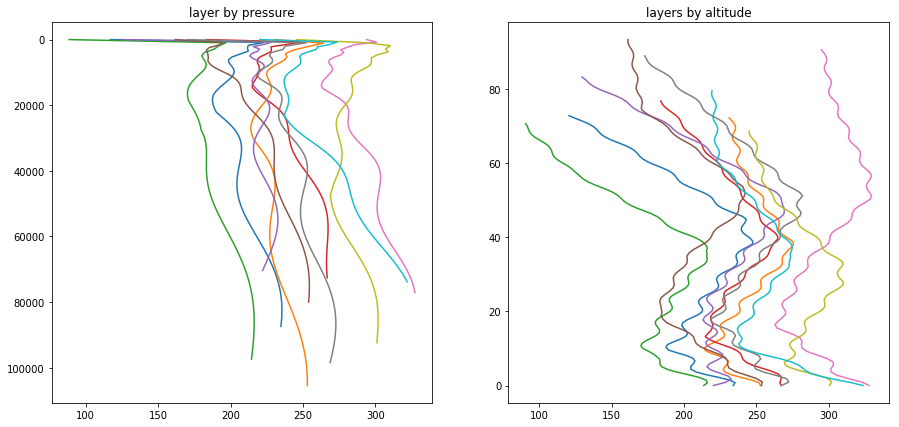

In [15]:
def CompositionalInheritance(parent_slot='base'):
    """ kinda like the decorator parttern, without all the BS
    """
    def decorator(cls):
        def geta(inst, attr):
            parent = inst.__dict__.get(parent_slot, None)
            if parent is not None and hasattr(parent, attr):
                return getattr(parent, attr)
            else:
                raise AttributeError(attr)

        def seta(inst, attr, val):
            parent = inst.__dict__.get(parent_slot, None)

            if attr not in dir(inst) and parent is not None and attr in dir(parent):
                setattr(parent, attr, val)
            else:
                inst.__dict__[attr] = val

        cls.__getattr__ = geta
        cls.__setattr__ = seta
        return cls
    return decorator


@CompositionalInheritance('atmosphere')
class NoisyLayeredAtmosphere:
    def __init__(self, atmosphere, a, b, c):
        self.atmosphere = atmosphere
        self.a, self.b, self.c = a, b, c

    def get_noise_by_altitude(self, altitude):
        assert altitude + self.c > 0, (altitude, self.c)
        return self.a * np.sin(altitude + self.b) / np.sqrt(altitude + self.c)

    def get_temperature_by_altitude(self, altitude):
        temp = self.atmosphere.get_temperature_by_altitude(altitude)
        noise = self.get_noise_by_altitude(altitude)
        return temp + noise
    
    def get_temperature_by_pressure(self, pressure):
        altitude = self.get_altitude_by_pressure(pressure)
        return self.get_temperature_by_altitude(altitude)


@CompositionalInheritance('random_atmosphere')
class RandomNoisyAtmosphere:
    def __init__(self, random_atmosphere, a_sampler, b_sampler, c_sampler):
        self.random_atmosphere = random_atmosphere
        self.a_sampler = a_sampler
        self.b_sampler = b_sampler
        self.c_sampler = c_sampler

    def sample(self):
        atmosphere = self.random_atmosphere.sample()
        a, b, c = self.a_sampler(), self.b_sampler(), self.c_sampler()
        return NoisyLayeredAtmosphere(atmosphere, a, b, c)

    
rnd = RandomNoisyAtmosphere(
    RandomAtmosphere(
        UniformSampler(273 - 100, 273 + 60),
        UniformSampler(70000, 110000),
        RandomLayer(UniformSampler(5, 25),  UniformSampler(-10, -0.1), gas_const),
        RandomLayer(UniformSampler(0.1, 3), UniformSampler(-1, 1), gas_const),
        RandomLayer(UniformSampler(8, 16),  UniformSampler(1, 2), gas_const),
        RandomLayer(UniformSampler(11, 19), UniformSampler(2, 3), gas_const),
        RandomLayer(UniformSampler(1, 7),   UniformSampler(-1, 1), gas_const),
        RandomLayer(UniformSampler(15, 25), UniformSampler(-5, -0.1), gas_const),
        RandomLayer(UniformSampler(10, 20), UniformSampler(-5, -0.1), gas_const),
    ),
    GaussianSamplerBetween(5, 25),
    GaussianSamplerBetween(-5, 5),
    GaussianSamplerBetween(1, 5),
)


plot_random_samples(rnd, 10)